# Analysis and Visualization of WikiSRAT data 

In this notebook, we create interactive visualizations of data in the WikiSRAT database.

Run within a conda environment specified in the included `environment.yml` file. 

Create the environment with either the Import button on Anaconda Navigator's Environments tab, or this Conda command in your terminal or console, replacing `path/environment.yml` with the full file pathway to the environment.yml file in the local cloned repository.

```bash
conda env create --file path/environment.yml
```

To update your environment, either use Anaconda Navigator, or run the following command:

```bash
conda env update --file path/environment.yml --prune
```

or

```bash
conda env create --file path/environment.yml --force
```

# Setup
* Import packages
* Login information 
* Define function to access data in database as pandas dataframes

In [1]:
# packages for data requests
import requests
import pandas as pd
from requests.auth import HTTPBasicAuth
import json
import os
import psycopg2


# packages for viz 
import matplotlib.pyplot as plt
from pynhd import NLDI, WaterData, NHDPlusHR
import pynhd as nhd
import geopandas as gpd
import plotly.express as px



# import geoviews as gv
# import geoviews.feature as gf
# from geoviews import opts
# from cartopy import crs 
# import geoviews.tile_sources as gts
# gv.extension('bokeh', 'matplotlib')
# import hvplot.pandas


In [2]:
# login information 
config_file = json.load(open('db_config.json'))
PG_CONFIG = config_file['PG_CONFIG']

_host = PG_CONFIG['host'],
_database = PG_CONFIG['database'],
_user = PG_CONFIG['user'],
_password = PG_CONFIG['password'],
_port = PG_CONFIG['port']

In [3]:
# connect to database 
_PG_Connection = psycopg2.connect(
        host=PG_CONFIG['host'],
        database=PG_CONFIG['database'],
        user=PG_CONFIG['user'],
        password=PG_CONFIG['password'],
        port=PG_CONFIG['port'])

In [4]:
def postgresql_to_dataframe(conn, select_query, column_names):
    """
    Tranform a SELECT query into a pandas dataframe
    """
    _cur = conn.cursor()
    try:
        _cur.execute(select_query)
    except (Exception, psycopg2.DatabaseError) as error:
        print("Error: %s" % error)
        _cur.close()
        return 1

    # We get a list of tupples
    tupples = _cur.fetchall()
    _cur.close()

    # Turn it into a pandas dataframe
    df = pd.DataFrame(tupples, columns=column_names)
    return df



# Fetch Data 

## Geometry from postgressql 
Fetch the data using the ```postgressql_to_dataframe``` function. 

In [5]:
%%time

# Define column names
colnames = ('comid','tploadrate_total','tploadate_conc','tnloadrate_total','tnloadate_conc','tssloadrate_total',
            'tssloadate_conc','catchment_hectares','watershed_hectares','tploadrate_total_ws','tnloadrate_total_ws',
            'tssloadrate_total_ws','maflowv','geom','catchment')

# Define table name for base and restoration runs
tablename_base = 'base_run'
tablename_rest = 'restoration_run'

# Define SQL query for base and restoration model runs 
base_model_select = 'SELECT * FROM wikiwtershedoutputs.{}'.format(tablename_base)
rest_model_select = 'SELECT * FROM wikiwtershedoutputs.{}'.format(tablename_rest)

# Call function
base_df = postgresql_to_dataframe(_PG_Connection, base_model_select, colnames)
rest_df = postgresql_to_dataframe(_PG_Connection, rest_model_select, colnames)

CPU times: user 875 ms, sys: 2 s, total: 2.87 s
Wall time: 3min 35s


In [6]:
base_df.head()

,comid,tploadrate_total,tploadate_conc,tnloadrate_total,tnloadate_conc,tssloadrate_total,tssloadate_conc,catchment_hectares,watershed_hectares,tploadrate_total_ws,tnloadrate_total_ws,tssloadrate_total_ws,maflowv,geom,catchment
0,9481248,68.5037,-9999.0000,987.2364,-9999.0000,93122.1233,-9999.0000,104.2306,403.6500,-9651.3095,-9651.3095,-9651.3095,0.4360,01050000E06A7F00000100000001020000C005000000F5...,01060000206A7F000001000000010300000001000000A3...
1,9484372,0.1543,-9999.0000,2.6515,-9999.0000,371.8530,-9999.0000,5.9355,14018.9400,-15.2968,-15.2968,-15.2968,0.0240,01050000E06A7F00000100000001020000C00200000025...,01060000206A7F0000010000000103000000010000001F...
2,9482436,30.1120,0.1350,424.2841,2.8368,32373.6023,128.4718,40.5590,299.3400,0.5038,10.5858,479.4035,1.2500,01050000E06A7F00000100000001020000C007000000FD...,01060000206A7F0000010000000103000000010000005E...
3,9485824,0.3676,-9999.0000,5.5931,-9999.0000,1262.2570,-9999.0000,20.2347,14037.3000,-79.5667,-79.5667,-79.5667,0.1250,01050000E06A7F00000100000001020000C008000000A0...,01060000206A7F00000100000001030000000100000024...
4,9482410,0.0075,0.0651,0.1267,1.9647,16.9213,63.8749,0.2698,2195.0100,0.2689,8.1145,263.8116,10.1450,01050000E06A7F00000100000001020000C00300000091...,01060000206A7F00000100000001030000000100000006...


The geometry format from postGIS is not compatible with geopandas. Instead, need to convert postgis to geopandas dataframe:

https://geopandas.org/docs/reference/api/geopandas.GeoDataFrame.from_postgis.html



In [7]:
%%time

from sqlalchemy import create_engine  
db_connection_url = "postgresql://{}:{}@{}:{}/{}".format(_user[0], _password[0], _host[0], _port, _database[0])
con = create_engine(db_connection_url)
sql = 'SELECT * FROM wikiwtershedoutputs.{}'.format(tablename_base)
df = gpd.GeoDataFrame.from_postgis(sql, con)

CPU times: user 1.47 s, sys: 998 ms, total: 2.47 s
Wall time: 1min 26s


In [8]:
df.head()

,comid,tploadrate_total,tploadate_conc,tnloadrate_total,tnloadate_conc,tssloadrate_total,tssloadate_conc,catchment_hectares,watershed_hectares,tploadrate_total_ws,tnloadrate_total_ws,tssloadrate_total_ws,maflowv,geom,catchment
0,9481248,68.5037,-9999.0000,987.2364,-9999.0000,93122.1233,-9999.0000,104.2306,403.65,-9651.3095,-9651.3095,-9651.3095,0.436,MULTILINESTRING Z ((460837.156 4373029.884 0.0...,01060000206A7F000001000000010300000001000000A3...
1,9484372,0.1543,-9999.0000,2.6515,-9999.0000,371.8530,-9999.0000,5.9355,14018.94,-15.2968,-15.2968,-15.2968,0.024,MULTILINESTRING Z ((456773.961 4370732.984 0.0...,01060000206A7F0000010000000103000000010000001F...
2,9482436,30.1120,0.1350,424.2841,2.8368,32373.6023,128.4718,40.5590,299.34,0.5038,10.5858,479.4035,1.250,MULTILINESTRING Z ((461163.451 4372698.329 0.0...,01060000206A7F0000010000000103000000010000005E...
3,9485824,0.3676,-9999.0000,5.5931,-9999.0000,1262.2570,-9999.0000,20.2347,14037.30,-79.5667,-79.5667,-79.5667,0.125,MULTILINESTRING Z ((456808.468 4370948.649 0.0...,01060000206A7F00000100000001030000000100000024...
4,9482410,0.0075,0.0651,0.1267,1.9647,16.9213,63.8749,0.2698,2195.01,0.2689,8.1145,263.8116,10.145,MULTILINESTRING Z ((460675.630 4373470.534 0.0...,01060000206A7F00000100000001030000000100000006...


In [9]:
df = df.to_crs(epsg=4326)


<AxesSubplot:>

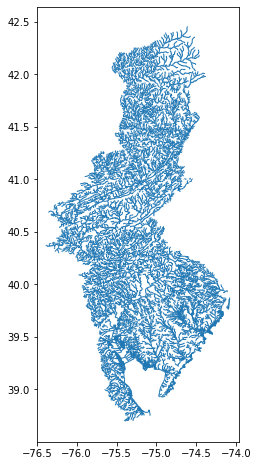

In [10]:
df.plot(lw=1, figsize=(8, 8))

The problem with this method is that this function looks for a column named 'geom', therefore it does not recognize the catchments geometry. 

For the time being, I will just use the pandas geodataframe that we retrieve using ```pynhd``` and merge that with columns from the above query. 

In the future, we may want to explore how we can format the database so that the geometry of both catchments can be found/captured. 

The following script doesn't work because the 'catchment' column is not labeled geometry or geom. 

In [11]:
# db_connection_url = "postgres://{}:{}@{}:{}/{}".format(_user[0], _password[0], _host[0], _port, _database[0])
# con = create_engine(db_connection_url)
# sql = 'SELECT catchment FROM wikiwtershedoutputs.{} as geom'.format(tablename_base)
# df = gpd.GeoDataFrame.from_postgis(sql, con)

## Geometry from pynhd (catchments)

In [12]:
%%time

# get catchment geometry
wd_cat = WaterData("catchmentsp")
print(wd_cat)
comids = [int(c) for c in base_df.comid.to_list()]
print(comids[0])
catchments = wd_cat.byid("featureid", comids)

Connected to the WaterData web service on GeoServer:
URL: https://labs.waterdata.usgs.gov/geoserver/wmadata/ows
Version: 2.0.0
Layer: wmadata:catchmentsp
Output Format: application/json
Output CRS: epsg:4326
9481248
CPU times: user 5.3 s, sys: 132 ms, total: 5.43 s
Wall time: 6.12 s


In [13]:
# merge with dataframes
catchments.columns = ["geometry", "gridcode", "comid", "sourcefc", "areqsqkm", "shape_length", "shape_area"]
base_df = base_df.merge(catchments, on='comid')

CPU times: user 4.87 s, sys: 18 ms, total: 4.89 s
Wall time: 4.83 s


<AxesSubplot:>

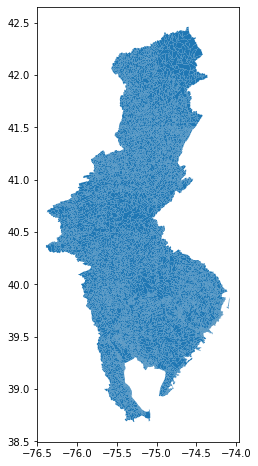

In [14]:
%%time
# convert to gpd and plot 
base_gpd = gpd.GeoDataFrame(base_df)
base_gpd.plot(lw=1, figsize=(8, 8))

In [15]:
base_gpd.head()

,comid,tploadrate_total,tploadate_conc,tnloadrate_total,tnloadate_conc,tssloadrate_total,tssloadate_conc,catchment_hectares,watershed_hectares,tploadrate_total_ws,...,tssloadrate_total_ws,maflowv,geom,catchment,geometry,gridcode,sourcefc,areqsqkm,shape_length,shape_area
0,9481248,68.5037,-9999.0000,987.2364,-9999.0000,93122.1233,-9999.0000,104.2306,403.6500,-9651.3095,...,-9651.3095,0.4360,01050000E06A7F00000100000001020000C005000000F5...,01060000206A7F000001000000010300000001000000A3...,"MULTIPOLYGON (((-75.46713 39.49311, -75.46844 ...",1693655,NHDFlowline,1.043170,0.054900,1.092355e-04
1,9484372,0.1543,-9999.0000,2.6515,-9999.0000,371.8530,-9999.0000,5.9355,14018.9400,-15.2968,...,-15.2968,0.0240,01050000E06A7F00000100000001020000C00200000025...,01060000206A7F0000010000000103000000010000001F...,"MULTIPOLYGON (((-75.50493 39.48325, -75.50566 ...",1693308,NHDFlowline,0.057009,0.010068,5.968493e-06
2,9482436,30.1120,0.1350,424.2841,2.8368,32373.6023,128.4718,40.5590,299.3400,0.5038,...,479.4035,1.2500,01050000E06A7F00000100000001020000C007000000FD...,01060000206A7F0000010000000103000000010000005E...,"MULTIPOLYGON (((-75.45742 39.50054, -75.45641 ...",1695064,NHDFlowline,0.406030,0.038794,4.252053e-05
3,9485824,0.3676,-9999.0000,5.5931,-9999.0000,1262.2570,-9999.0000,20.2347,14037.3000,-79.5667,...,-79.5667,0.1250,01050000E06A7F00000100000001020000C008000000A0...,01060000206A7F00000100000001030000000100000024...,"MULTIPOLYGON (((-75.50037 39.48660, -75.50152 ...",1693748,NHDFlowline,0.200162,0.019948,2.095683e-05
4,9482410,0.0075,0.0651,0.1267,1.9647,16.9213,63.8749,0.2698,2195.0100,0.2689,...,263.8116,10.1450,01050000E06A7F00000100000001020000C00300000091...,01060000206A7F00000100000001030000000100000006...,"MULTIPOLYGON (((-75.45761 39.50989, -75.45795 ...",1693167,NHDFlowline,0.002700,0.002330,2.827746e-07


In [16]:
# convert to numeric:
for col in  ['tploadrate_total','tploadate_conc','tnloadrate_total','tnloadate_conc','tssloadrate_total',
            'tssloadate_conc','catchment_hectares','watershed_hectares','tploadrate_total_ws','tnloadrate_total_ws',
            'tssloadrate_total_ws','maflowv']:
    base_gpd[col] = pd.to_numeric(base_gpd[col])

CPU times: user 4.44 s, sys: 18.3 ms, total: 4.46 s
Wall time: 4.4 s


<AxesSubplot:>

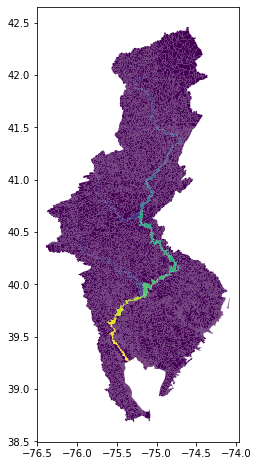

In [17]:
%%time
base_gpd.plot(column='maflowv',  lw=1, figsize=(8, 8))

# Plot with Plotly

## px.chloropleth_mapbox

Un-comment out cells below to commit -- otherwise, the files are too large.

https://stackoverflow.com/questions/46891914/control-mapbox-extent-in-plotly-python-api

Remove borders: https://stackoverflow.com/questions/61420022/plotly-choropleth-without-borders

In [ ]:
%%time
fig = px.choropleth_mapbox(base_gpd,
                           geojson=base_gpd.geometry,
                           locations=base_gpd.index,
                           color='maflowv',
                           color_continuous_scale="Viridis",
                           # range_color=(0, 12),
                           # width=200,
                           mapbox_style="carto-positron",
                           zoom=6,
                           center = {"lat": 40.4604, "lon": -74.8334},
                           opacity=0.5,
                           height = 500,
                           # width = 100
                           labels={'Comid':'comid'}
                          )
fig.update_traces(marker_line_color='rgba(255,255,255,0)', selector=dict(type='choroplethmapbox')) #make the border transparent
fig.update_layout(margin={"r":300,"t":0,"l":300,"b":0})
# fig['layout']['geo']['subunitcolor']='rgba(0,0,0,0)'

fig.show()

## Plotting multiline

Extract latitudes and longitudes -- this is not great in plotly.

Maybe utlimately try something with bokeh and geopandas?
https://kodu.ut.ee/~kmoch/geopython2018/lessons/L5/interactive-map-bokeh.html

In [20]:
%%time

# plot lines https://plotly.com/python/lines-on-mapbox/
import numpy as np

lats = []
lons = []
names = []
colors = []

i = 0 
tot = len(df.geom)

for feature, name, mfv in zip(df.geom, df.comid, df.maflowv):

    if feature == None:
        pass
    else:
        linestrings = feature


        for linestring in linestrings:
            x, y = linestring.xy
            lats = np.append(lats, y)
            lons = np.append(lons, x)
            names = np.append(names, [name]*len(y))
            colors = np.append(colors, [mfv]*len(y))
            lats = np.append(lats, None)
            lons = np.append(lons, None)
            names = np.append(names, None)
            colors = np.append(colors, None)
    pct = round(i / tot * 100, 2)
    if pct % 10 == 0:
        print(str(pct) + "% done") 
    i += 1

0.0% done
10.0% done
10.0% done
20.0% done
20.0% done
30.0% done
30.0% done
40.0% done
40.0% done
50.0% done
60.0% done
60.0% done
70.0% done
70.0% done
80.0% done
80.0% done
90.0% done
90.0% done


NOTE: Sarah, this function above might be made much more efficient by avoiding the use of np.append() inside the loop. If I remember, np.append is very slow because it reallocates memory each time. List append is very fast, however, so its often recommened in these cases to create a list using the loop, then convert that list into an array in one final step.

Assign colors based on column value

In [ ]:
%%time
fig = px.line_mapbox(lat=lats, lon=lons, hover_name=names,
                     mapbox_style="carto-positron",
                     # color=colors,
                     zoom=6,
                     center = {"lat": 40.4604, "lon": -74.8334},
                     height=500
                    )
fig.update_layout(margin={"r":300,"t":0,"l":300,"b":0})
fig.show()

In [22]:
len(colors) == len(lats)

True

## go.Chloroplethmapbox

Different option within plotly, which includes option to remove borders:
* https://plotly.com/python/mapbox-county-choropleth/

In [23]:
# set up for chloropleth map 
base_gpd = base_gpd.to_crs(epsg=4326)
geo_df_g2_json = json.loads(base_gpd.to_json())

In [ ]:
%%time
import plotly.graph_objects as go

token = "pk.eyJ1Ijoic2pvcmRhbjI5IiwiYSI6ImNrc3Jzb2Y4ODBwbTYybnA3MjloZ2RjMHcifQ.6IVtsCFcLvhLFNl_IF9OqA"
fig = go.Figure(go.Choroplethmapbox(geojson=geo_df_g2_json,
                                    locations=base_gpd.index,
                                    z = base_gpd['maflowv'],
                                    colorscale="Viridis",
                                    marker_line_width=0,
#                                   #  height
                                   ))
fig.update_layout(mapbox_style="light", mapbox_accesstoken=token,
                  mapbox_zoom=6, mapbox_center = {"lat": 40.4604, "lon": -74.8334})
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

# Additional Geometry 

## Pour Points

In [27]:
%%time
pp_select = "SELECT * FROM datadrwi.focusareas_p2plus_pp WHERE phase like 'Phase 2 Plus' ORDER BY cluster, name, sub_focusarea"

db_connection_url = "postgresql://{}:{}@{}:{}/{}".format(_user[0], _password[0], _host[0], _port, _database[0])
con = create_engine(db_connection_url)
pp_df = gpd.GeoDataFrame.from_postgis(pp_select, con)

CPU times: user 28.7 ms, sys: 8.99 ms, total: 37.7 ms
Wall time: 1.54 s


In [19]:
pp_df.head()

,name,geom,cluster,sub_focusarea,nord,nordstop,strategy,url,totdasqkm,startnode,endnode,one,prot5imp,name_final,phase,change,newnord,newnordstop,comid
0,Brandywine Creek,MULTIPOINT (426134.666 4436083.420),Brandywine and Christina,2,1167,1177,restoration,None,47.2716,01010000206A7F00002AE98006C3021A41DD16434B15EC...,01010000206A7F0000E0F2EF6212001A4119AED5AF23EC...,1,8664.5907,Brandywine Creek Headwaters,Phase 2 Plus,None,64634,64644,4648484
1,Plum Run,MULTIPOINT (446367.110 4418423.865),Brandywine and Christina,1,928,930,restoration,None,9.3645,01010000206A7F0000A268DFD98B3E1B41FB78CC73CCDA...,01010000206A7F0000B1B0362AF24D1B41CB1E0A3895DC...,1,-9999.0000,Plum Run,Phase 2 Plus,None,64395,64397,4650736
2,Red Clay Creek,MULTIPOINT (437119.737 4412576.803),Brandywine and Christina,1,1497,1506,restoration,None,25.5645,01010000206A7F0000007884898EBB1A41662A04261FD2...,01010000206A7F0000D2C373B8D8AD1A418D6C8B032FD5...,1,-9999.0000,Red Clay Creek,Phase 2 Plus,None,64964,64973,4651004
3,Red Clay Creek,MULTIPOINT (439245.207 4411407.832),Brandywine and Christina,2,1477,1485,restoration,None,9.0477,01010000206A7F0000F0A535C642D21A417D6AFB8AEBD3...,01010000206A7F000098B8E2C47ED61A41FD32B1C8F3D5...,1,-9999.0000,Red Clay Creek,Phase 2 Plus,None,64944,64952,4650938
4,White Clay Creek,MULTIPOINT (428013.039 4407372.837),Brandywine and Christina,1,1378,1380,restoration,None,15.9606,01010000206A7F0000C4274F3E09211A411BC1312FF0CF...,01010000206A7F0000114AACF5A2141A41F4386DE6E3D2...,1,2730.7526,White Clay Creek,Phase 2 Plus,None,64845,64847,4651064


<AxesSubplot:>

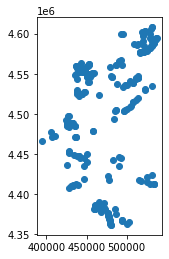

In [20]:
pp_df.plot()

## DRWI Clusters

Cluster geometry created in 2013.

In [22]:
cl_select = "SELECT * FROM spatial.clustersv"
cl_df = gpd.GeoDataFrame.from_postgis(cl_select, con)
cl_df.head()

,gid,objectid,labels,label_id,sum_acres,acres,ncontrb_a,acres_ans,name,shape_leng,shape_area,geom
0,1,0,Poconos and Kittatinny,5,866281.173581,866281.173581,865592.657330,865593,Poconos and Kittatinny,5.179372,0.368441,"MULTIPOLYGON (((511922.413 4619793.062, 511948..."
1,2,0,Middle Schuylkill,3,501873.916855,501873.916855,501532.547416,501533,Middle Schuylkill,0.000000,0.000000,"MULTIPOLYGON (((398250.125 4483059.000, 398241..."
2,3,0,Brandywine and Christina,1,360524.071274,360524.071274,360270.075107,360270,Brandywine and Christina,0.000000,0.000000,"MULTIPOLYGON (((448782.249 4434220.000, 448840..."
3,4,0,New Jersey Highlands,4,441794.273605,441794.273605,441441.637355,441442,New Jersey Highlands,0.000000,0.000000,"MULTIPOLYGON (((486254.217 4533019.500, 486403..."
4,5,0,Schuylkill Highlands,6,109186.312480,109186.312480,109107.796416,109108,Schuylkill Highlands,0.000000,0.000000,"MULTIPOLYGON (((445764.281 4456450.500, 445828..."


In [44]:
# set projection 
cl_df = cl_df.to_crs(epsg=4326)
pp_df = pp_df.to_crs(epsg=4326)

<AxesSubplot:>

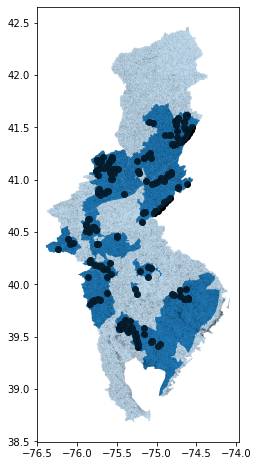

In [45]:
fig, ax = plt.subplots(figsize=(8, 8))

cl_df.plot(ax=ax)
pp_df.plot(ax=ax, color='k')
base_gpd.plot(ax=ax, color=None, alpha=0.3, edgecolor='k', linewidth=0.1)

### Spatial Join 

Find which comids are in clusters. 
* spatial join:https://geopandas.org/gallery/spatial_joins.html

In [50]:
# df_within = gpd.sjoin(cl_df, base_gpd, how="right", op="within")

In [63]:
# ensure that they have the same projection 
cl_df.crs == base_gpd.crs

True

shapely: https://shapely.readthedocs.io/en/stable/manual.html
* within: misses boundary
* intersects: includes outer ring

To try:
* Will this be fixed if we can pull geometry directly from the postgis table? 
* Projection management?
* Catchment centroid insetad of the shape

In [114]:
import shapely.speedups
shapely.speedups.enable() 
pip_mask = base_gpd.within(cl_df.loc[0, 'geom'].buffer(0.005)) # try adding buffer to include inner ring -
pip_data = base_gpd.loc[pip_mask]

(-75.6, -74.4)

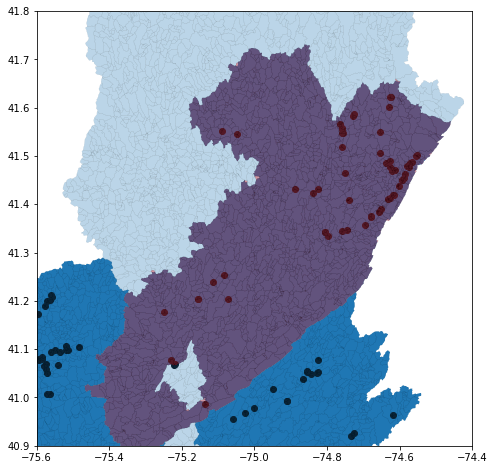

In [115]:
fig, ax = plt.subplots(figsize=(8, 8))

cl_df.plot(ax=ax)
pp_df.plot(ax=ax, color='k')
base_gpd.plot(ax=ax, color=None, alpha=0.3, edgecolor='k', linewidth=0.1)
pip_data.plot(ax=ax, color='red', alpha=0.3, edgecolor='k', linewidth=0.1)
ax.set_ylim(40.9, 41.8)
ax.set_xlim(-75.6, -74.4)

Next steps:
* Zoom dependent rendering 
* Drop down menus - maybe (low priority)
* Add polylines to plotly map? 
* Flip on and off different features?

Questions:
* units?
* Does Mike have info on larger geographic areas and their relaton to comids?

Future next steps:
* Arithmetic on columns 
* Organized efforts into geographic **clusters** --> **focus areas**  --> **pour points** 
* HUC12 (similar map)

**Units:** 
* Concentration: mg/L
* loadrate_totals: kg/yr
* loadrate_total_ws: attempt to get loadrate totals to kg/ha: fails if mean annual flow doesn't exist = ((loadate_conc * 28.3168 * 31557600 / 1000000) * maflowv) / watershed_hectares 

**Current Questions**: 
* can we try renaming catchment column to geom or geom1 or something like that -- get geopandas to recognize?
* focus areas from pour points -- all upstream area from pour point within cluster? Or just between two pour points?
* Is there a focus area shapefile?
* How hard/easy would it be to assign each COMID a focus area and cluster in the table we've been working with?